In [1]:
packages <- c(
  "tuneR",      # WAV file processing
  "seewave",    # WAV file processing
  "TSA",        # Periodograms
  "fda.usc",    # Functional data processing
  "plot3D"
)

for (package in packages) {
  if (!requireNamespace(package, quietly = TRUE)) {
    install.packages(package)
  }

  library(package, character.only = TRUE)
}

Warning message:
"package 'tuneR' was built under R version 4.3.3"
Warning message:
"package 'seewave' was built under R version 4.3.3"
Warning message:
"package 'TSA' was built under R version 4.3.3"

Attaching package: 'TSA'


The following object is masked from 'package:seewave':

    spec


The following object is masked from 'package:tuneR':

    periodogram


The following objects are masked from 'package:stats':

    acf, arima


The following object is masked from 'package:utils':

    tar


Warning message:
"package 'fda.usc' was built under R version 4.3.3"
Loading required package: fda

Warning message:
"package 'fda' was built under R version 4.3.3"
Loading required package: splines

Loading required package: fds

Warning message:
"package 'fds' was built under R version 4.3.3"
Loading required package: rainbow

Warning message:
"package 'rainbow' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: pcaPP

Warning message:
"package 'pca

In [2]:
get_filepaths <- function(dir, subset) {
  return(file.path(dir, readLines(file.path(dir, subset))))
}

dataset_dir <- "SpeechCommands"
train_paths <- get_filepaths(dataset_dir, "train.txt")
val_paths <- get_filepaths(dataset_dir, "val.txt")
test_paths <- get_filepaths(dataset_dir, "test.txt")

sample_count <- data.frame(
  Subset = c("Train", "Validation", "Test"),
  Utterances = c(length(train_paths), length(val_paths), length(test_paths))
)
sample_count

Subset,Utterances
<chr>,<int>
Train,28501
Validation,3338
Test,3789


In [4]:
load_audio_as_fdata <- function(filepath, func = mean) {
  audio <- tuneR::readWave(filepath)
  signal <- audio@left

  # Center the signal
  signal <- signal - mean(signal)

  pgram <- TSA::periodogram(signal, plot = FALSE)
  log_pgram <- log(pgram$spec + 1e-10)
  freqs <- pgram$freq * audio@samp.rate / 1000

  # Interpolate the log periodogram onto a coarser grid
  reduced_freqs <- seq(min(freqs), max(freqs), length.out = 800)
  log_pgram <- approx(x = freqs, y = log_pgram, xout = reduced_freqs)$y

  fdata_obj <- fda.usc::fdata(
    matrix(log_pgram, nrow = 1),
    argvals = reduced_freqs,
    rangeval = range(reduced_freqs),
    names = list(
      main = "Google Speech Commands",
      xlab = "Frequencies (kHz)",
      ylab = "log(Power)"
    )
  )

  return(fdata_obj)
}

load_dataset <- function(filepaths) {
  fdata_list <- list()
  labels <- c()

  for (filepath in filepaths) {
    # Extract class label from file path
    label <- strsplit(filepath, "/")[[1]][2]

    fdata_list[[filepath]] <- load_audio_as_fdata(filepath)
    labels <- c(labels, label)
  }

  # Convert list of fdata objects to single fdata object
  fdata <- do.call(c, fdata_list)

  # Convert class labels to factor
  labels <- factor(labels, levels = c(
    "zero", "one", "two", "three", "four",
    "five", "six", "seven", "eight", "nine"
  ))

  return(list(data = fdata, labels = labels))
}

# train <- load_dataset(train_paths)
# val <- load_dataset(val_paths)
test <- load_dataset(test_paths)

# Pick which dataset to visualize
dataset <- test

### Find optimal smoothing parames with B-Spline basis 

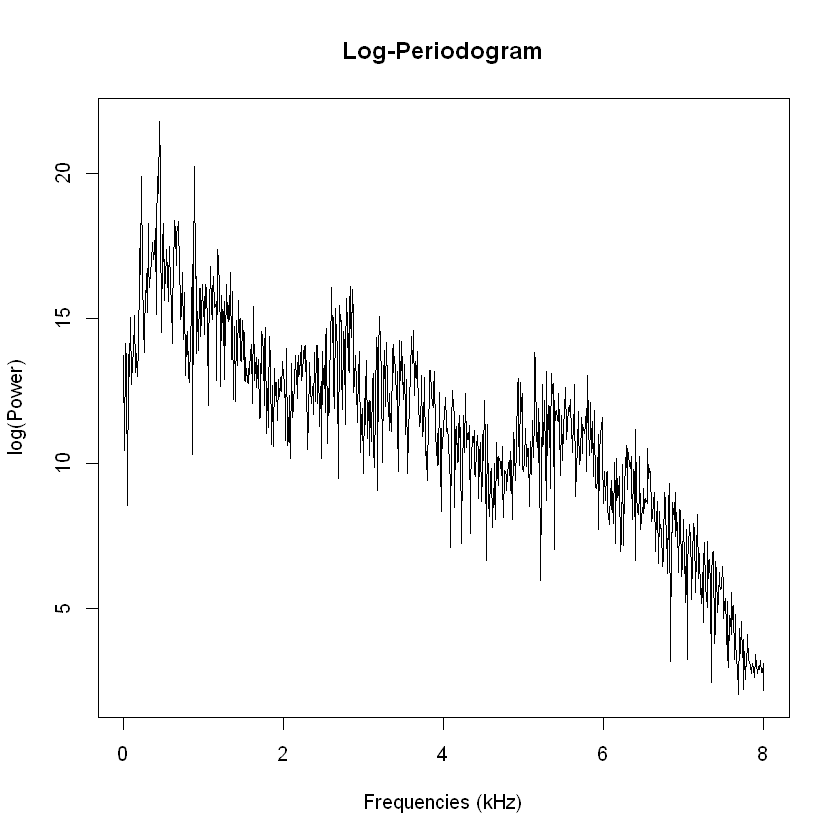

In [5]:
num_samples <- 1
plot(
  dataset$data[1:num_samples, ],
  main = "Log-Periodogram"
)

Optimal smoothing parameter: 0.01715261 
Optimal number of basis functions: 150

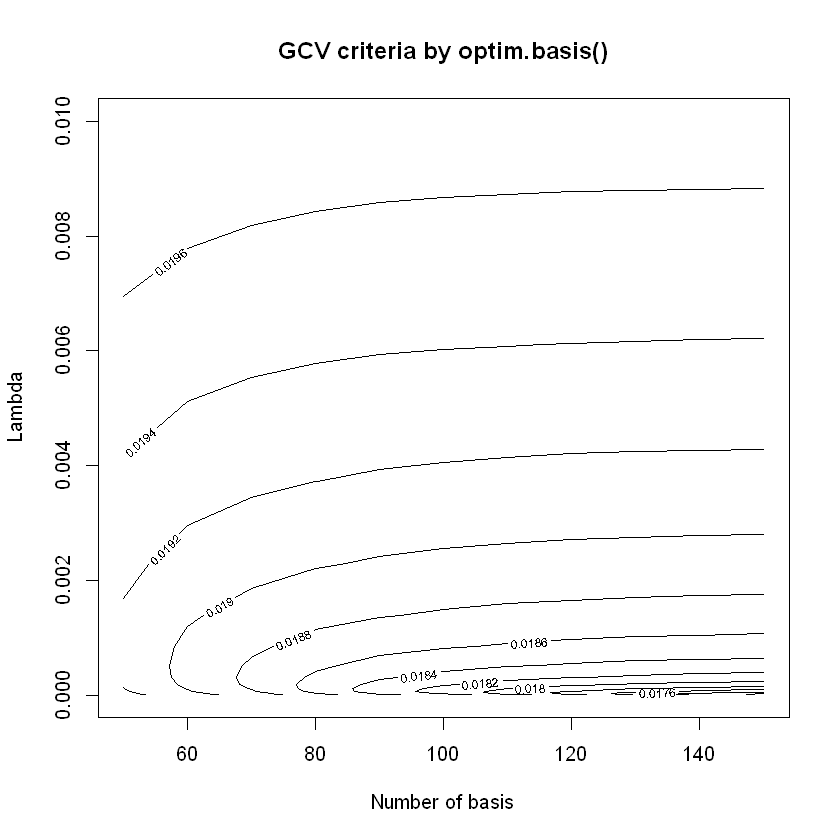

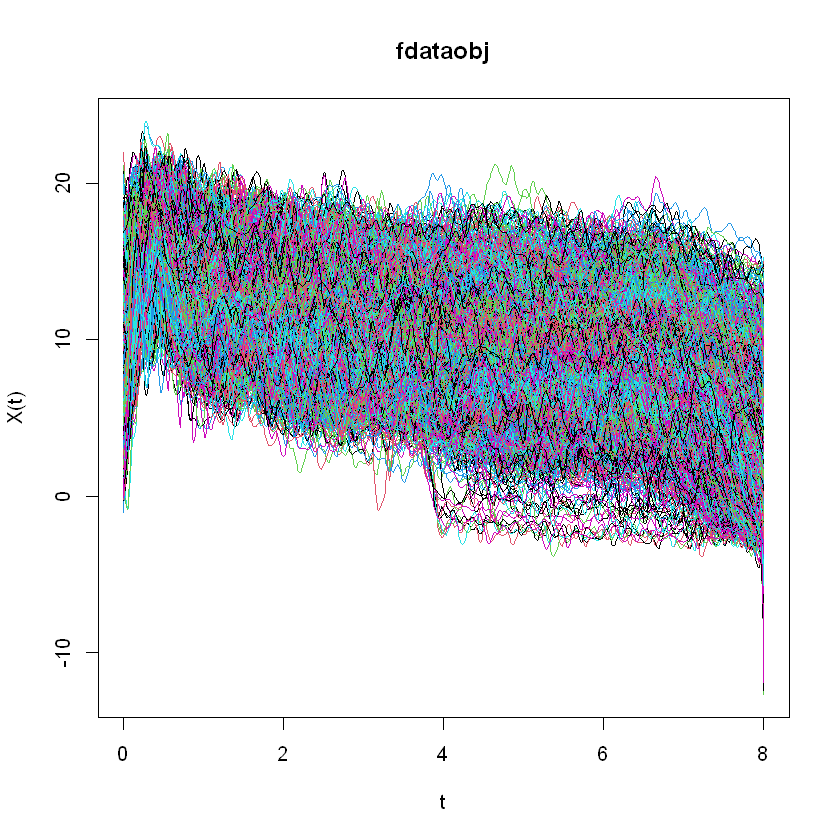

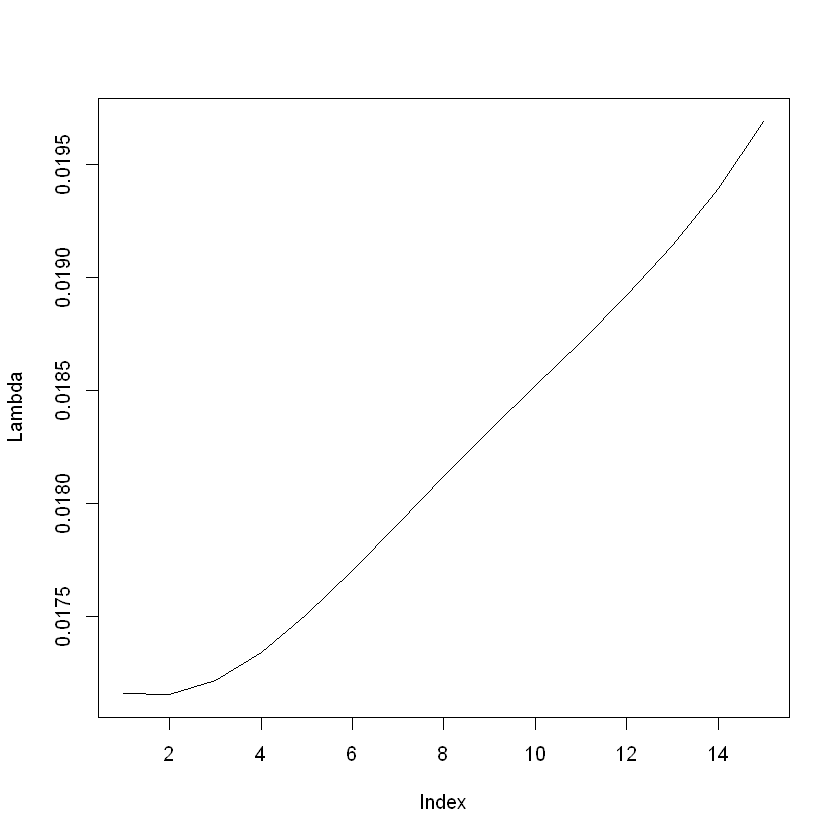

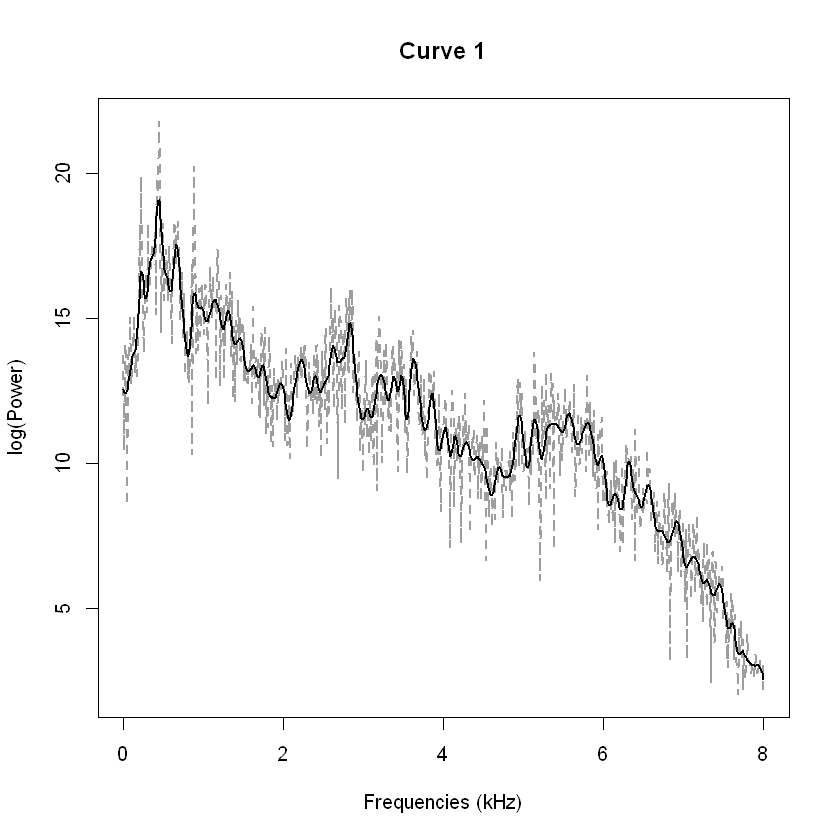

In [23]:
# Sequence of lambda smoothing parameters
lambda <- 10^seq(-5, -2, len = 15)

# Different numbers of basis functions to test
numbasis <- seq(50, 150, by = 10)

bspline <- fda.usc::optim.basis(
  dataset$data,
  lambda = lambda,
  numbasis = numbasis,
  type.basis = "bspline"
)

cat(
  "Optimal smoothing parameter:", bspline$gcv.opt,
  "\nOptimal number of basis functions:", bspline$numbasis.opt
)

contour(
  numbasis, lambda,
  bspline$gcv,
  ylab = "Lambda",
  xlab = "Number of basis",
  main = "GCV criteria by optim.basis()"
)
plot(bspline$fdata.est)

plot(
  bspline$gcv[sprintf("%d", bspline$numbasis.opt), ], type = "l",
  ylab = "Lambda"
)

index <- 1
plot(
  dataset$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(bspline$fdata.est[index, ], col = 1, lty = 1, lwd = 2)

### Find optimal smoothing parames with Fourier basis 

Optimal smoothing parameter: 0.01805384 
Optimal number of basis functions: 150

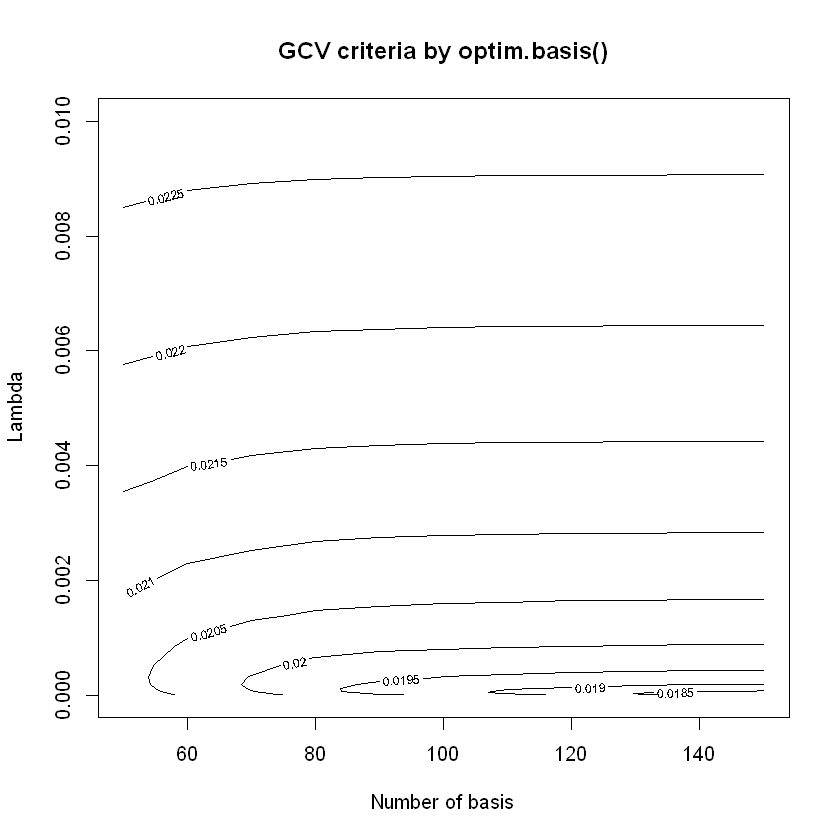

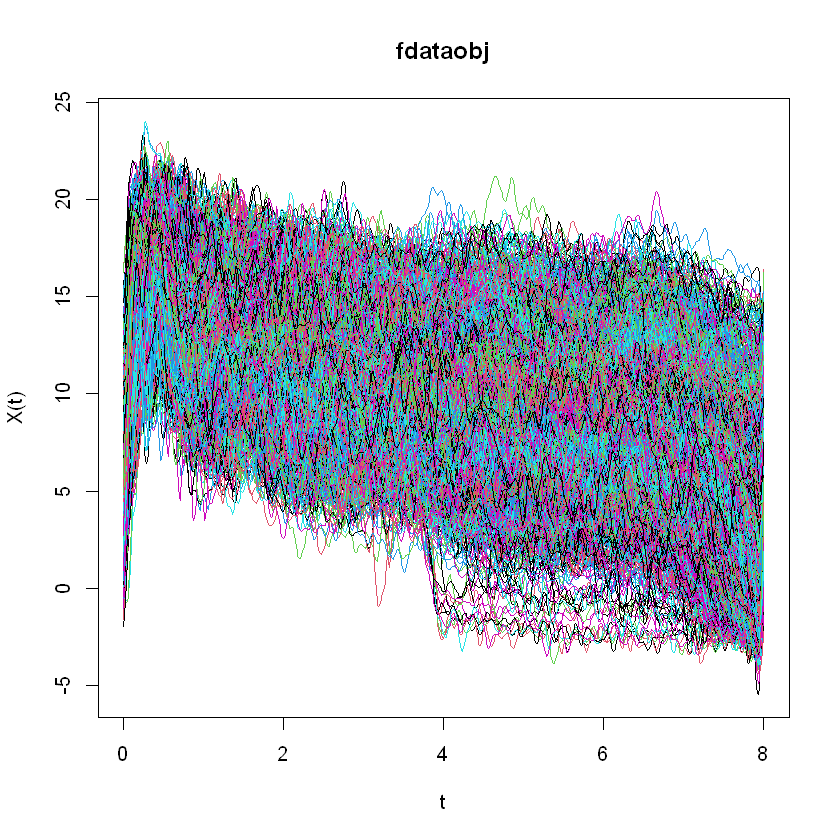

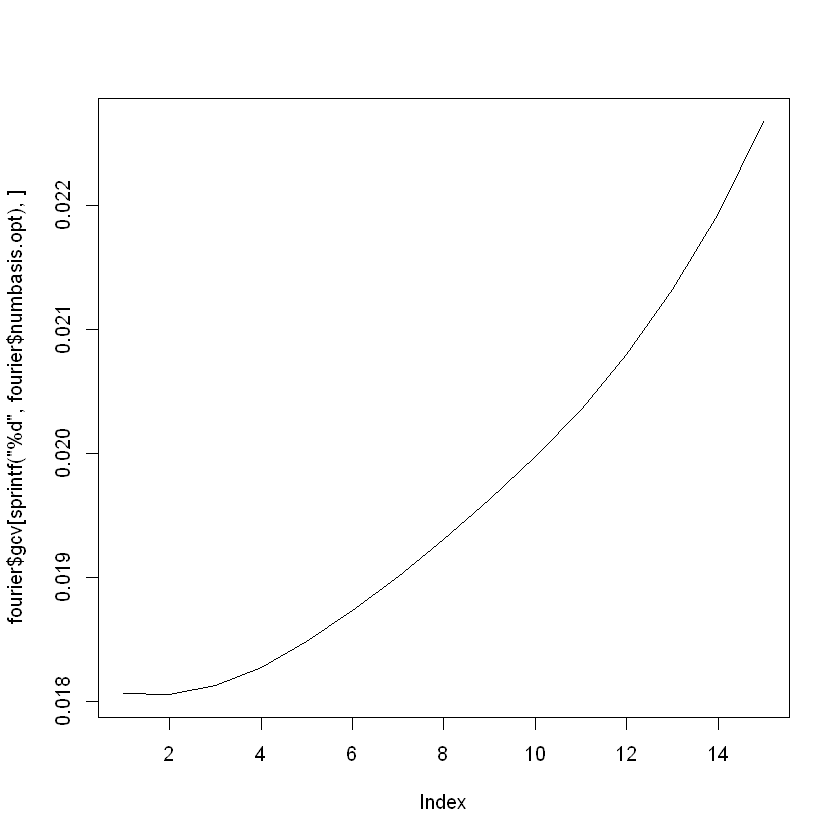

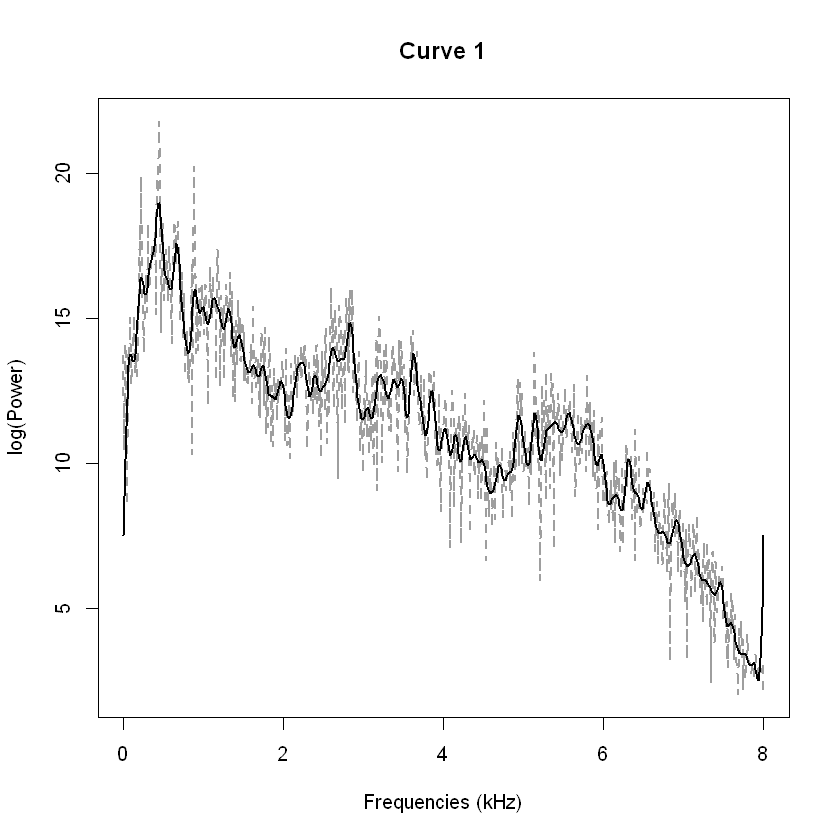

In [24]:
# Sequence of lambda smoothing parameters
lambda <- 10^seq(-5, -2, len = 15)

# Different numbers of basis functions to test
numbasis <- seq(50, 150, by = 10)

fourier <- fda.usc::optim.basis(
  dataset$data,
  lambda = lambda,
  numbasis = numbasis,
  type.basis = "fourier"
)

cat(
  "Optimal smoothing parameter:", fourier$gcv.opt,
  "\nOptimal number of basis functions:", fourier$numbasis.opt
)

contour(
  numbasis, lambda,
  fourier$gcv,
  ylab = "Lambda",
  xlab = "Number of basis",
  main = "GCV criteria by optim.basis()"
)
plot(fourier$fdata.est)

plot(fourier$gcv[sprintf("%d", fourier$numbasis.opt), ], type = "l")

index <- 1
plot(
  dataset$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(fourier$fdata.est[index, ], col = 1, lty = 1, lwd = 2)

### Find optimal smoothing parames with Nadaraya-Watson

Optimal smoothing parameter: 0.0235631

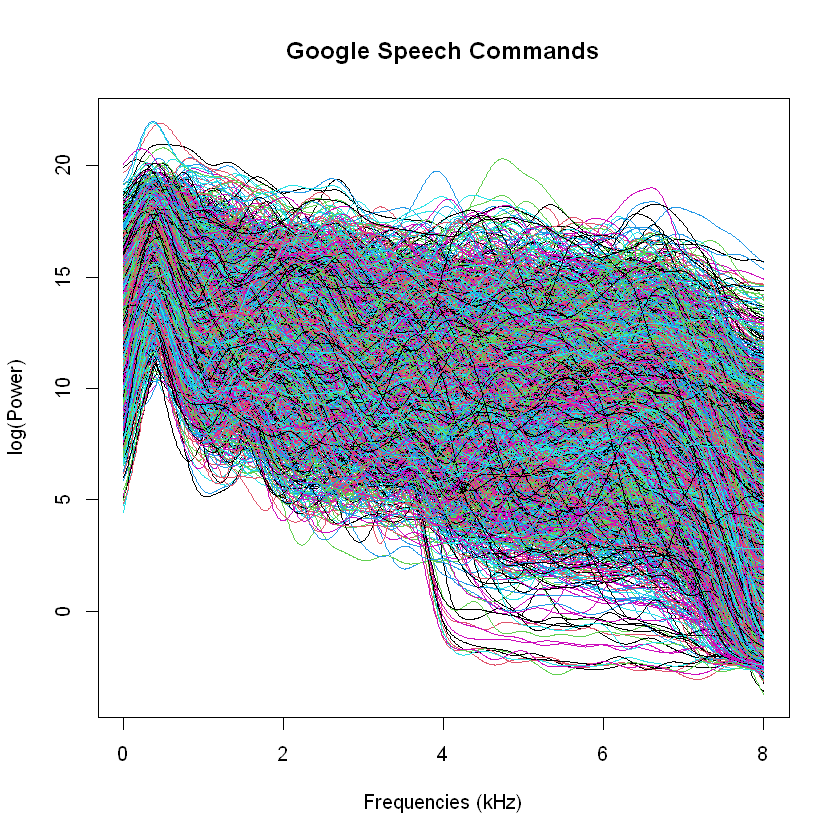

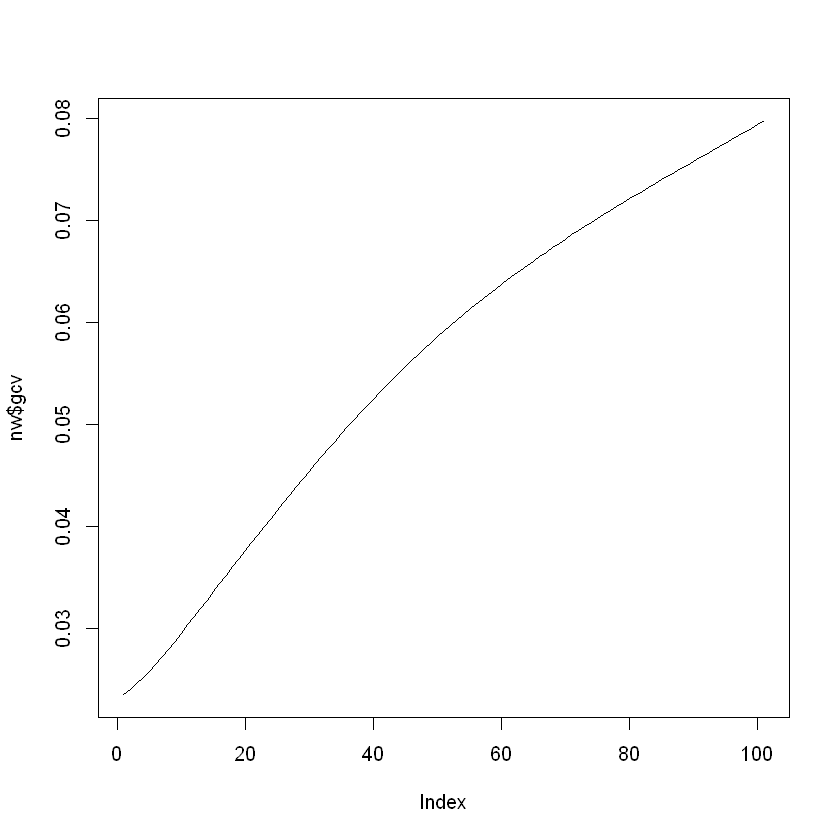

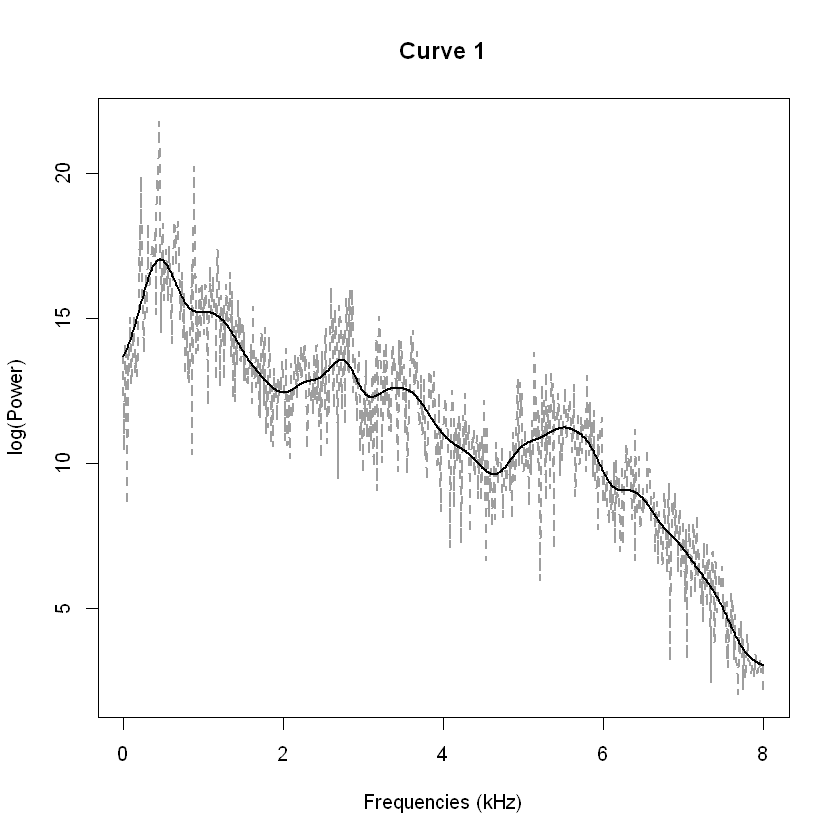

In [12]:
nw <- fda.usc::optim.np(
  dataset$data,
  type.S = S.NW,
  par.CV = list(criteria = "GCV")
)
cat("Optimal smoothing parameter:", nw$gcv.opt)

plot(nw$fdata.est)
plot(nw$gcv, type = "l")

index <- 1
plot(
  dataset$data[index, ],
  main = "Curve 1",
  lty = 2, lwd = 2, col = 8
)
lines(nw$fdata.est[index, ], col = 1, lty = 1, lwd = 2)


**Functional Data Summary**
---------------------------------------------------

**Functional Data (`data`)**
   - Number of Observations (Curves): 3789 
   - Number of Evaluation Points (argvals): 800 
   - Range of Argument Values (argvals): 0.001 to 8 
   - Data Value Range: -23.0258509299405 to 26.6994429995572 

**Class Labels (`labels`)**
   - Unique Classes: 10 
   - Class Distribution:

 zero   one   two three  four  five   six seven eight  nine 
  385   364   384   377   368   408   374   376   376   377 
---------------------------------------------------


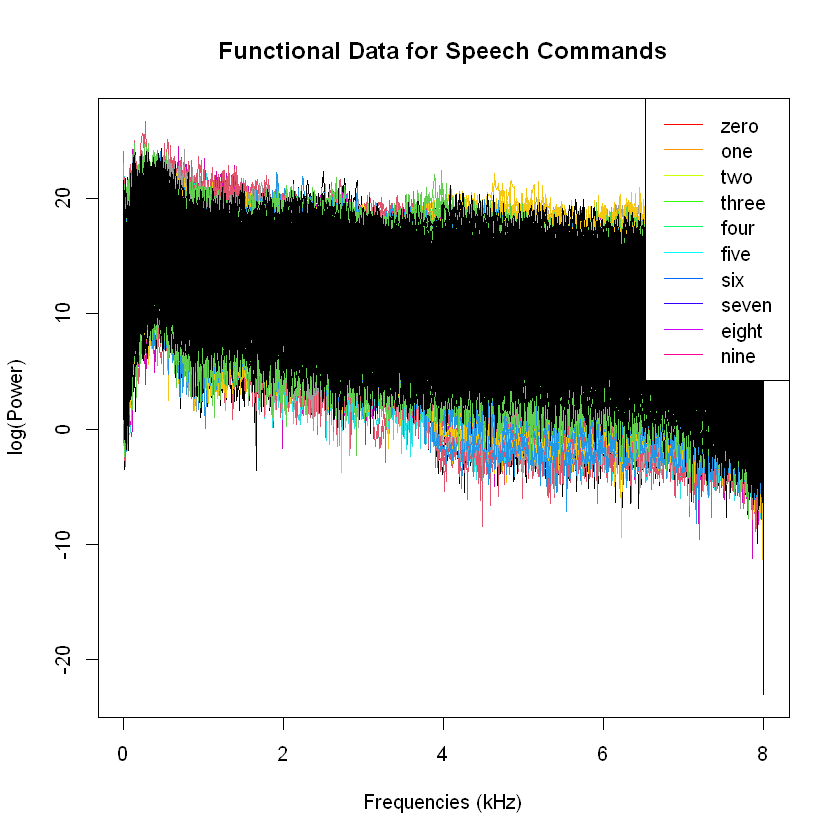

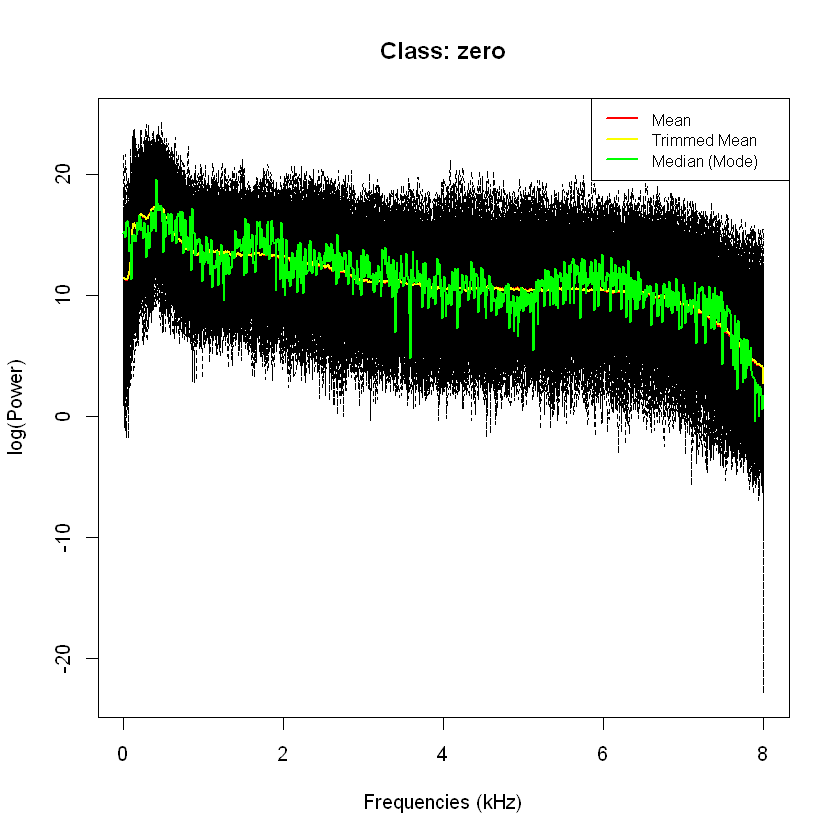

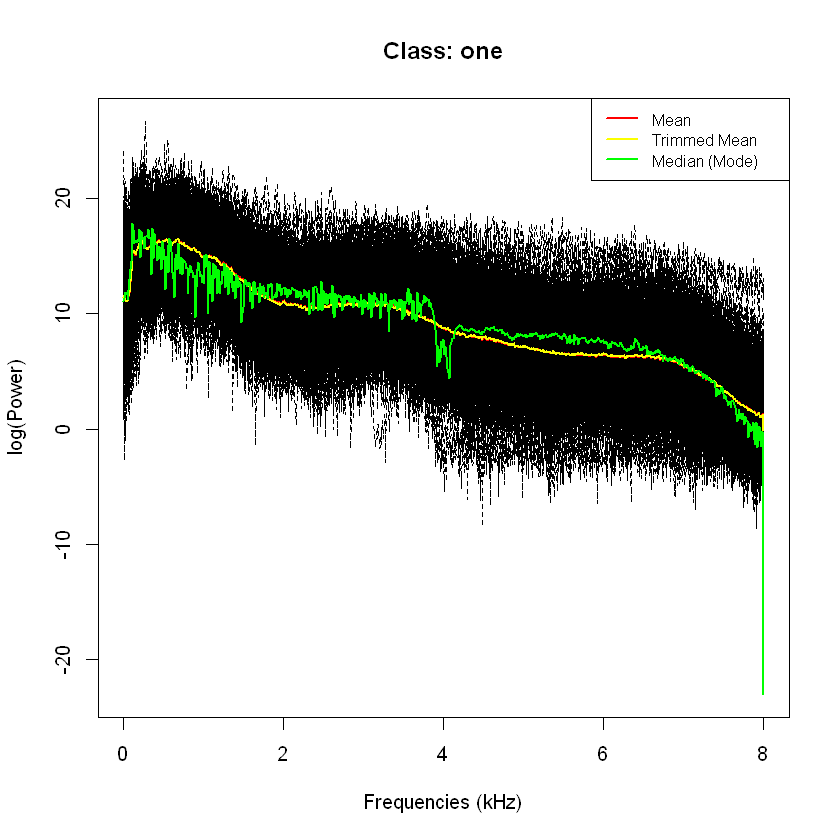

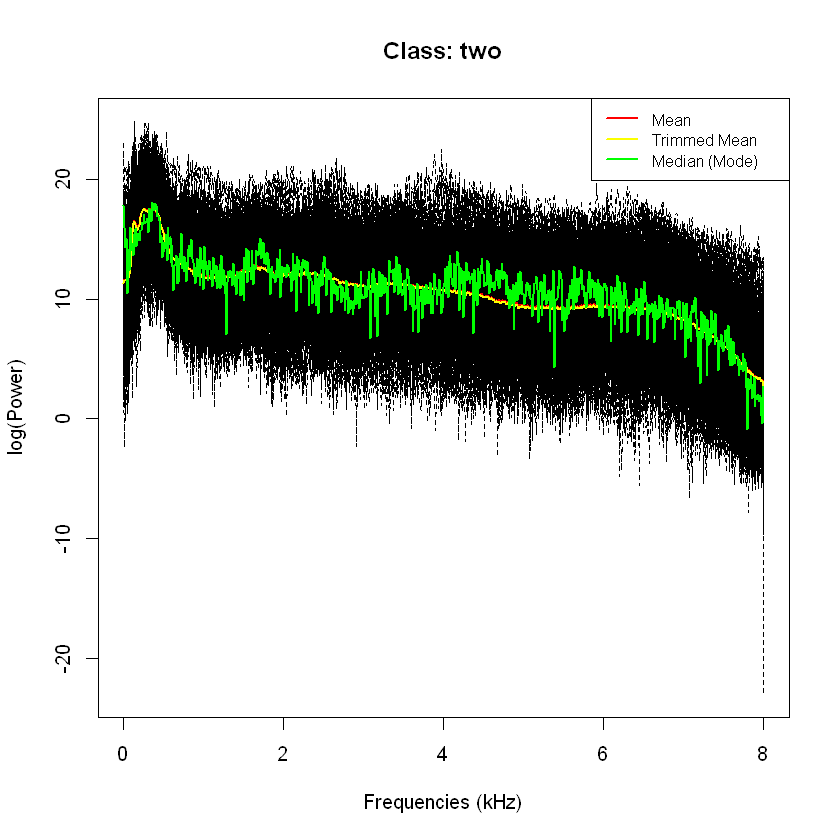

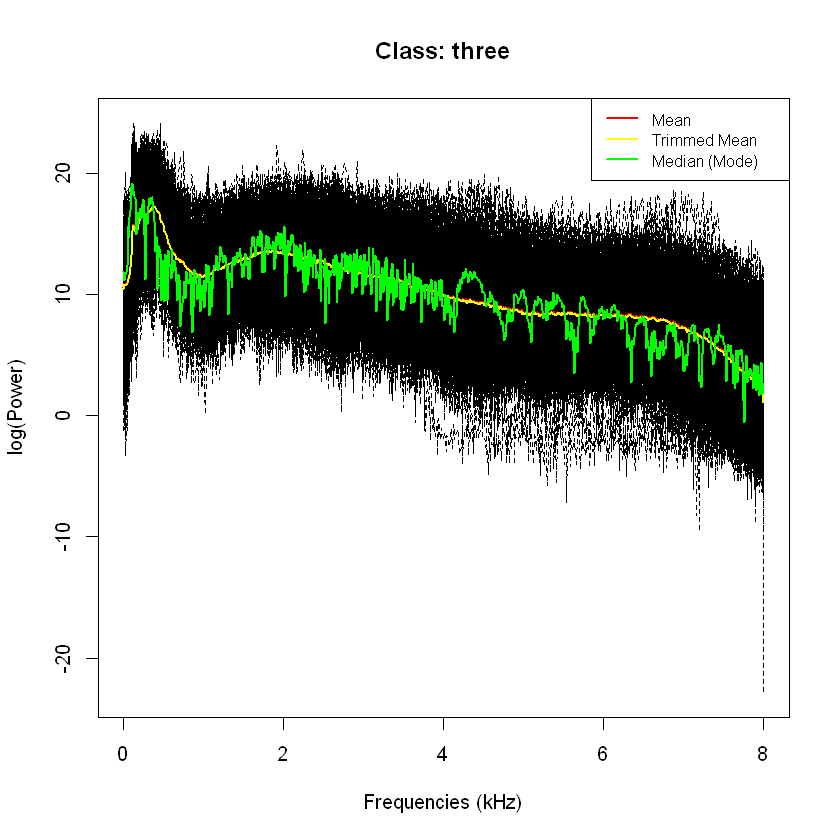

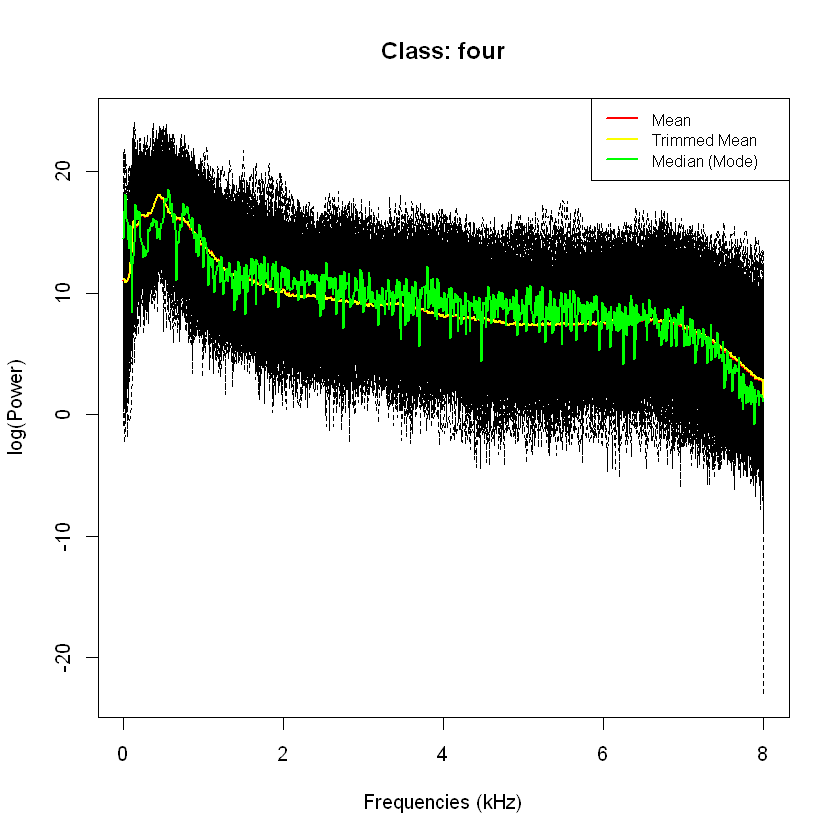

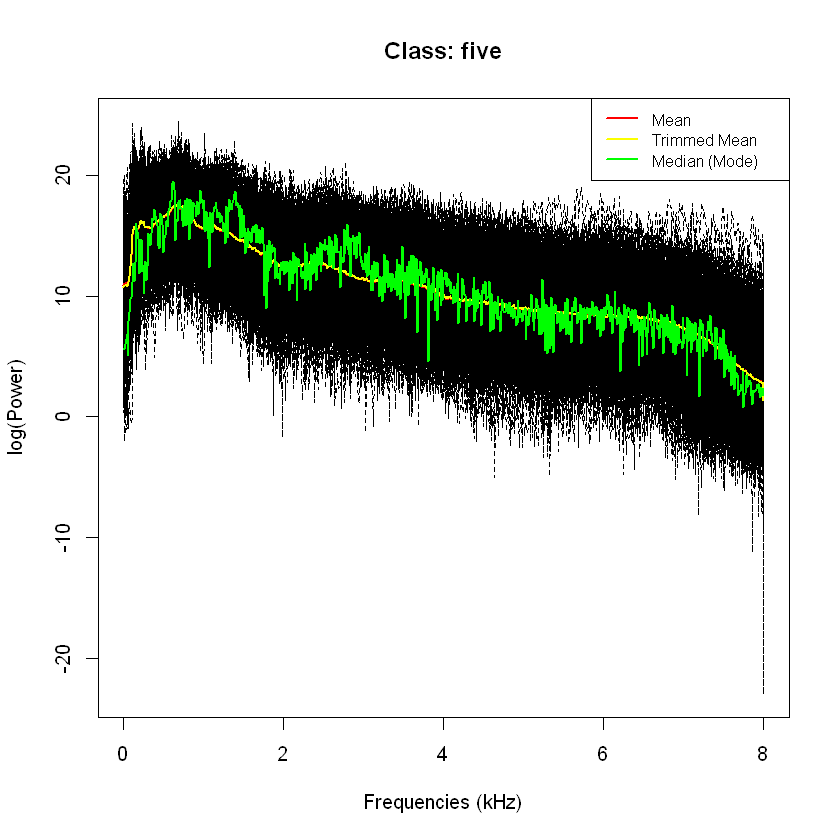

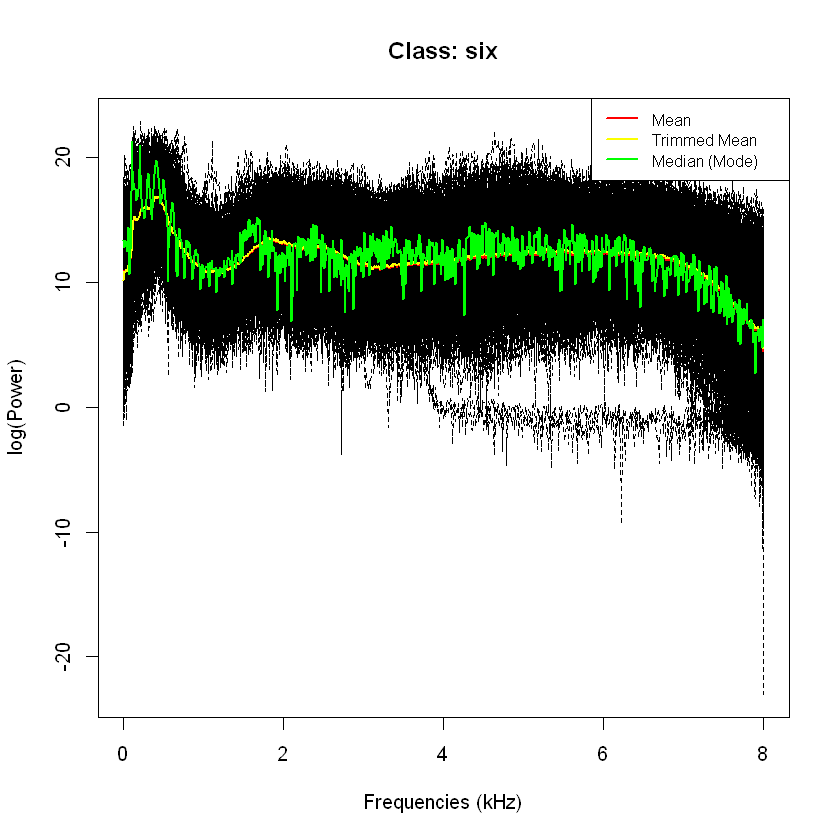

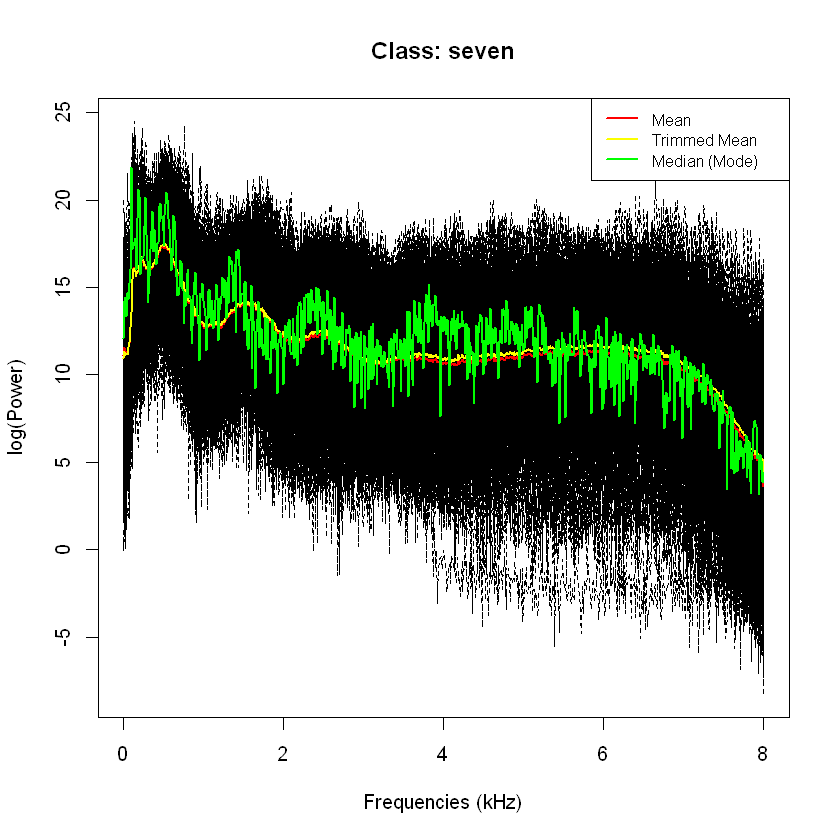

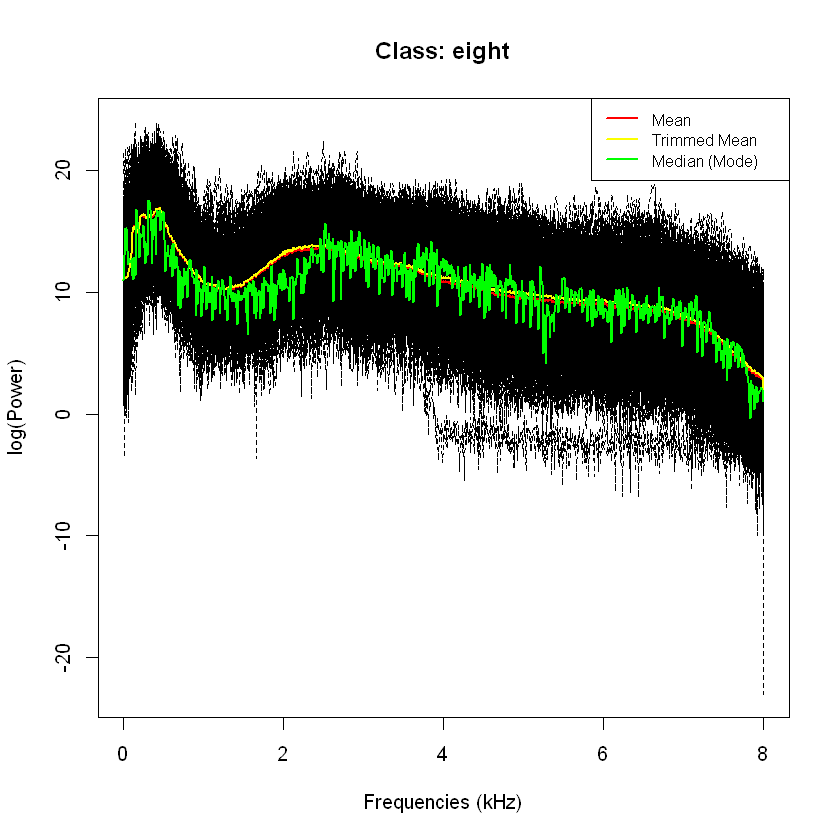

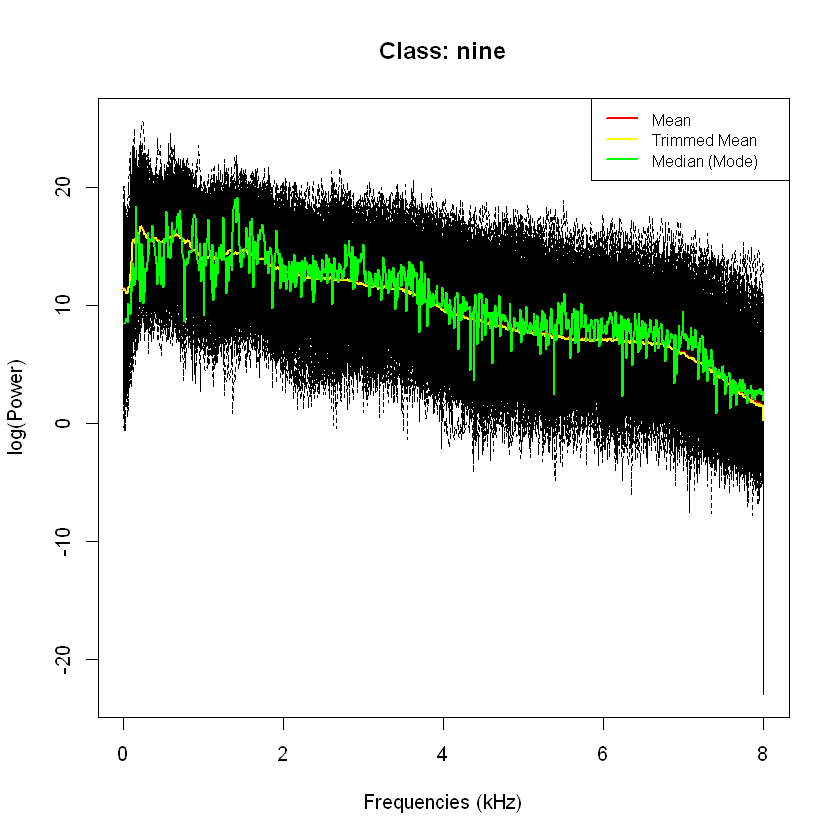

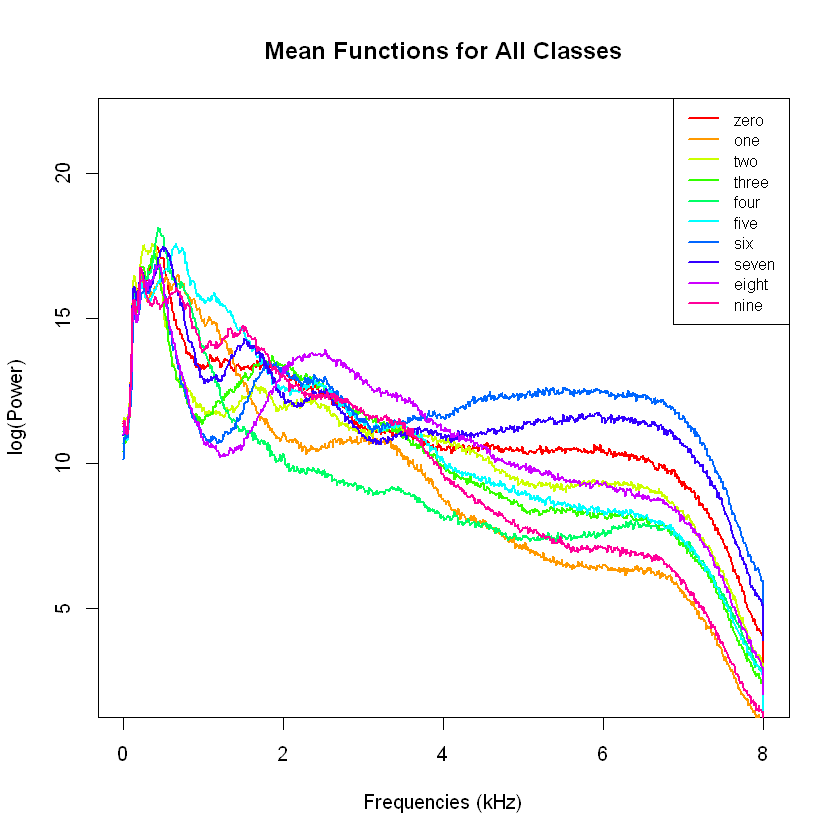

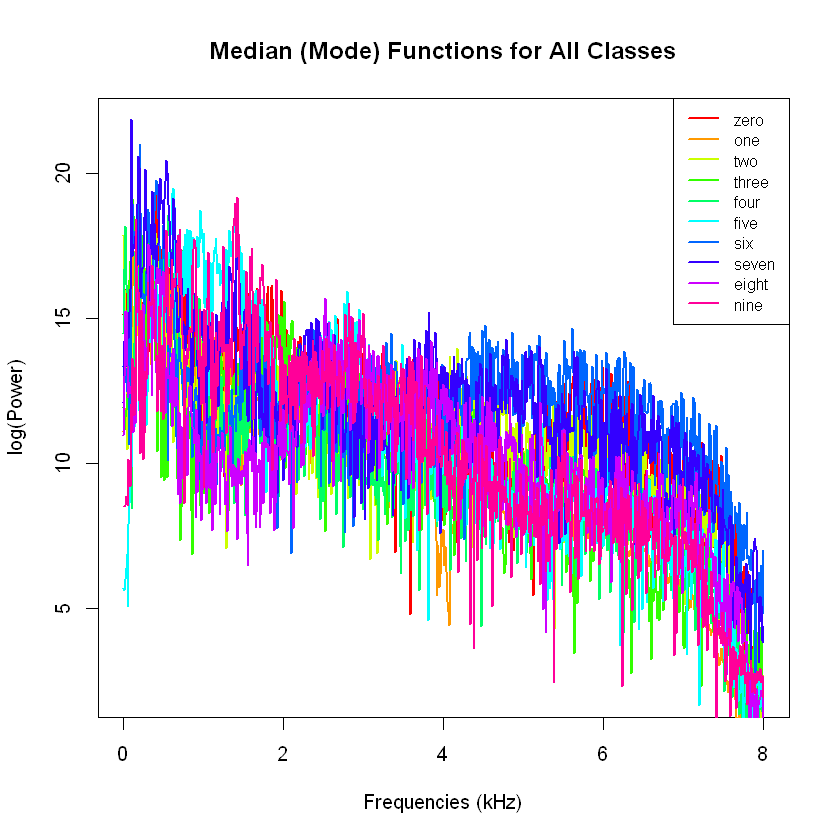

In [25]:
summarize_fdata <- function(dataset) {
  cat("\n**Functional Data Summary**\n")
  cat("---------------------------------------------------\n")

  cat("\n**Functional Data (`data`)**\n")
  cat("   - Number of Observations (Curves):",
      nrow(dataset$data$data), "\n")
  cat("   - Number of Evaluation Points (argvals):",
      length(dataset$data$argvals), "\n")
  cat("   - Range of Argument Values (argvals):",
      paste(range(dataset$data$argvals), collapse = " to "), "\n")

  cat("   - Data Value Range:",
      paste(range(dataset$data$data), collapse = " to "), "\n")

  cat("\n**Class Labels (`labels`)**\n")
  cat("   - Unique Classes:", length(levels(dataset$labels)), "\n")
  cat("   - Class Distribution:\n")
  print(table(dataset$labels))

  cat("---------------------------------------------------\n")

  # PLOT ALL CURVES COLORED BY CLASS
  plot(
    dataset$data,
    col = as.numeric(dataset$labels),
    main = "Functional Data for Speech Commands"
  )
  legend(
    "topright",
    legend = levels(dataset$labels),
    col = rainbow(length(levels(dataset$labels))),
    lty = 1
  )

  # FOR EACH CLASS CREATE A SEPARATE PLOT WITH MEAN AND MEDIAN CURVE
  trimmed_mean_curves <- list()
  median_mode_curves <- list()

  for (class in levels(dataset$labels)) {
    class_indices <- which(dataset$labels == class)
    class_fdata <- dataset$data[class_indices, ]

    mean_curve <- fda.usc::func.mean(class_fdata)
    trim_mean_curve <- fda.usc::func.trim.FM(class_fdata, trim = 0.1)
    med_mode_curve <- fda.usc::func.med.mode(class_fdata)

    trimmed_mean_curves <- append(trimmed_mean_curves, list(trim_mean_curve))
    median_mode_curves <- append(median_mode_curves, list(med_mode_curve))

    # Plot only the curves for the current class
    plot(class_fdata, main = paste("Class:", class), col = "black", lty = 2)

    lines(mean_curve, col = "red", lwd = 2, lty = 1)
    lines(trim_mean_curve, col = "#fbff00", lwd = 2, lty = 1)
    lines(med_mode_curve, col = "green", lwd = 2, lty = 1)

    legend(
      "topright",
      legend = c("Mean", "Trimmed Mean", "Median (Mode)"),
      col = c("red", "#fbff00", "green"),
      lty = 1, lwd = 2, cex = 0.8
    )
  }

  # PLOT TRIMMED MEAN CURVES FOR EACH CLASS
  plot(
    dataset$data[1, ],
    col = "white",
    main = "Mean Functions for All Classes"
  )
  class_colors <- rainbow(length(levels(dataset$labels)))
  legend_labels <- c()

  for (i in seq_along(levels(dataset$labels))) {
    class <- levels(dataset$labels)[i]
    lines(trimmed_mean_curves[[i]], col = class_colors[i], lwd = 2, lty = 1)
    legend_labels <- c(legend_labels, class)
  }
  legend(
    "topright",
    legend = legend_labels,
    col = class_colors,
    lty = 1, lwd = 2, cex = 0.8
  )

  # PLOT MEDIAN (MODE DEPTH) CURVES FOR EACH CLASS
  plot(
    dataset$data[1, ],
    col = "white",
    main = "Median (Mode) Functions for All Classes"
  )
  class_colors <- rainbow(length(levels(dataset$labels)))
  legend_labels <- c()

  for (i in seq_along(levels(dataset$labels))) {
    class <- levels(dataset$labels)[i]
    med_mode_curve <- tryCatch(
      median_mode_curves[[i]],
      error = function(e) NULL  # Return NULL if median computation fails
    )

    # Only plot if median exists
    if (!is.null(med_mode_curve)) {
      lines(med_mode_curve, col = class_colors[i], lwd = 2, lty = 1)
      legend_labels <- c(legend_labels, class)
    }
  }

  legend(
    "topright",
    legend = legend_labels,
    col = class_colors,
    lty = 1, lwd = 2, cex = 0.8
  )
}

summarize_fdata(dataset)

In [26]:
# Pick which kernel to use
dataset$kernel <- nw

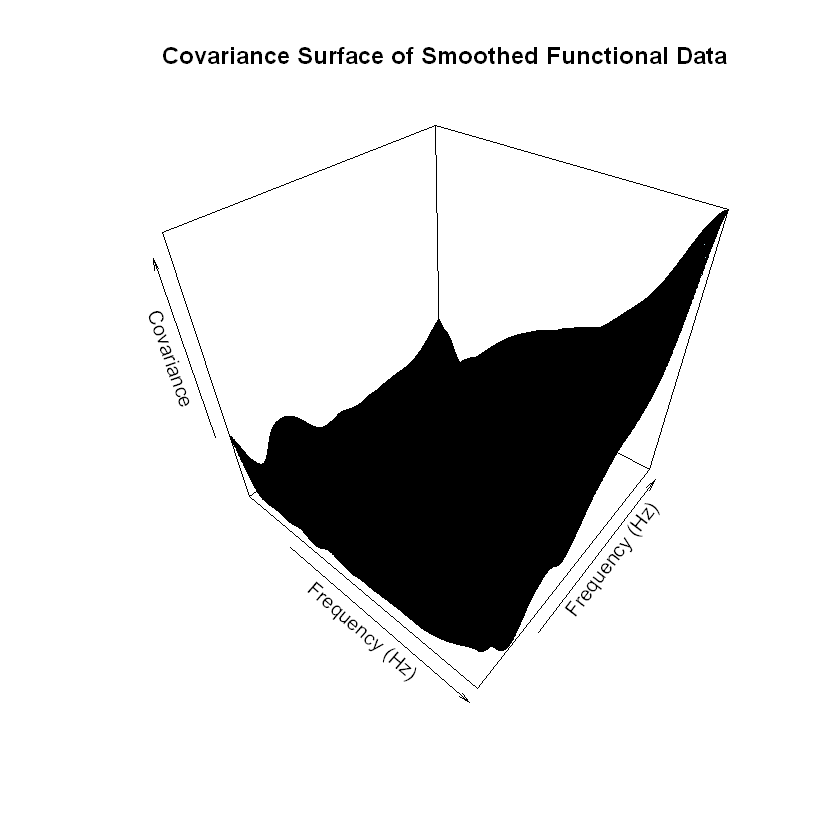

In [27]:
persp3D(
  x = dataset$kernel$fdata.est$argvals,
  y = dataset$kernel$fdata.est$argvals,
  z = cov(dataset$kernel$fdata.est$data),
  col = "lightblue", border = "black",
  xlab = "Frequency (Hz)",
  ylab = "Frequency (Hz)",
  zlab = "Covariance",
  main = "Covariance Surface of Smoothed Functional Data"
  # , phi = 0, theta = 135
)

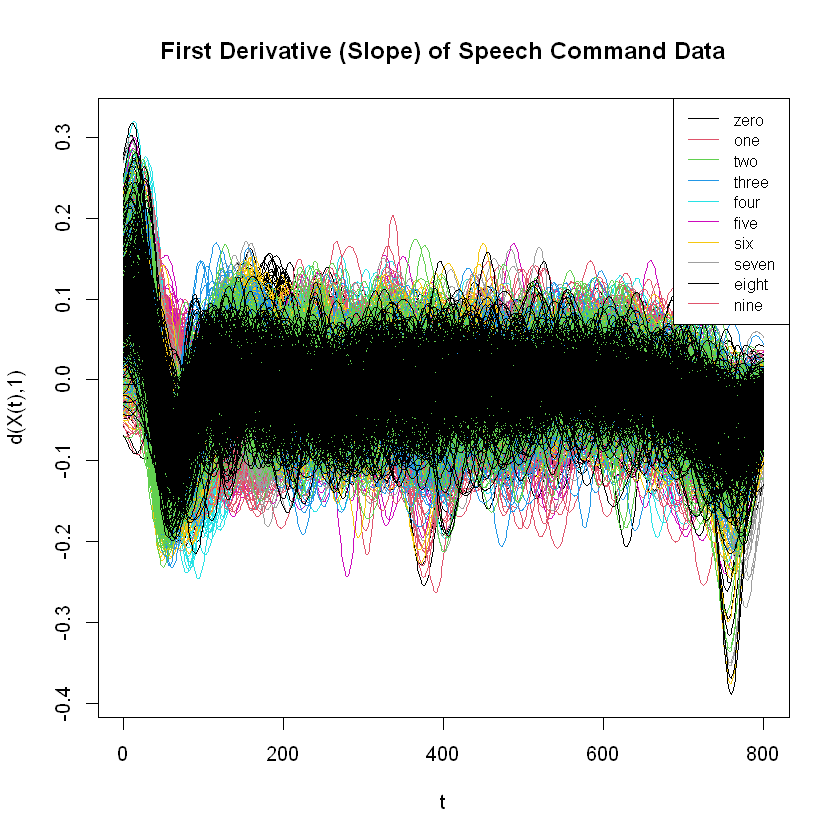

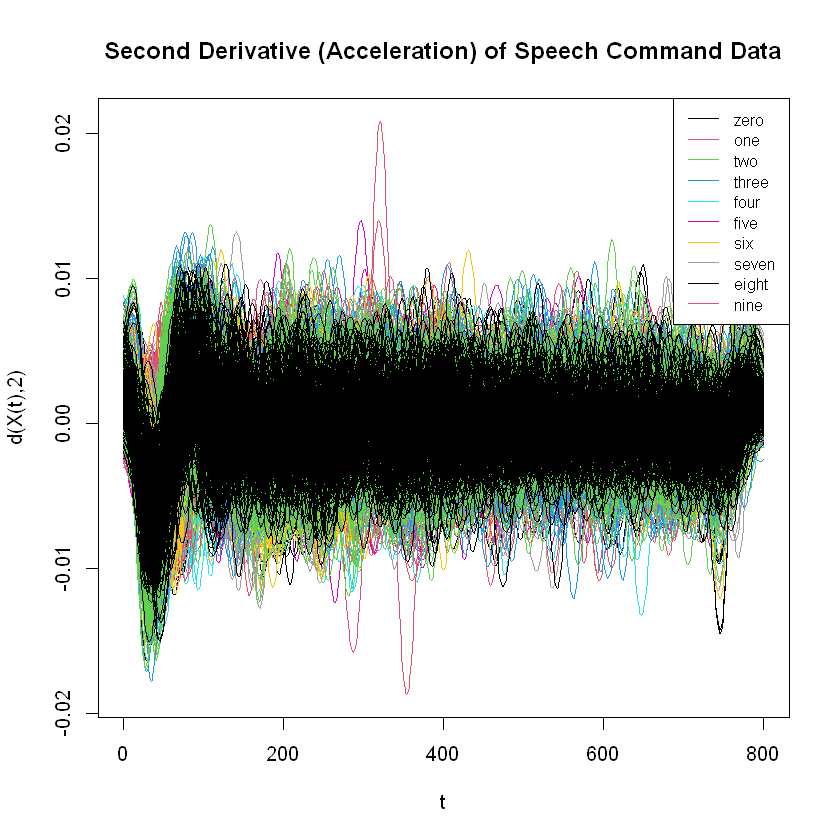

In [28]:
# data <- dataset$data
data <- dataset$kernel$fdata.est$data

# Compute first derivative (slope) of functional data
first_derivative <- fdata.deriv(data, nderiv = 1)

# Compute second derivative (acceleration)
second_derivative <- fdata.deriv(data, nderiv = 2)

plot(
  first_derivative,
  main = "First Derivative (Slope) of Speech Command Data",
  col = as.numeric(dataset$labels)
)

legend(
  "topright",
  legend = levels(dataset$labels),
  col = seq_along(levels(dataset$labels)),
  lty = 1, cex = 0.8
)

plot(
  second_derivative,
  main = "Second Derivative (Acceleration) of Speech Command Data",
  col = as.numeric(dataset$labels)
)

legend(
  "topright",
  legend = levels(dataset$labels),
  col = seq_along(levels(dataset$labels)),
  lty = 1, cex = 0.8
)

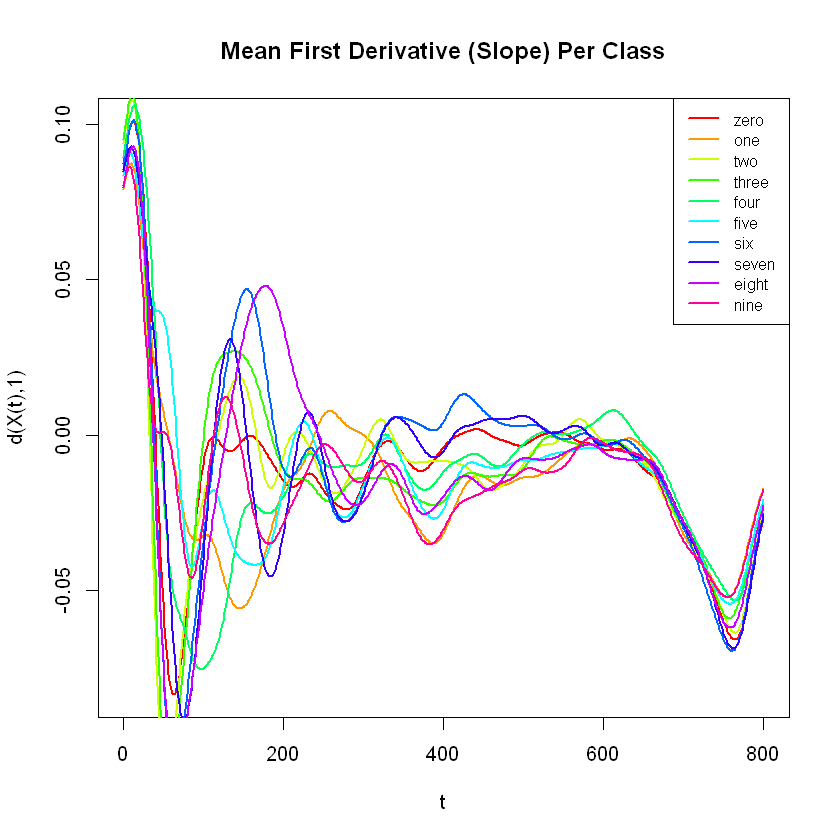

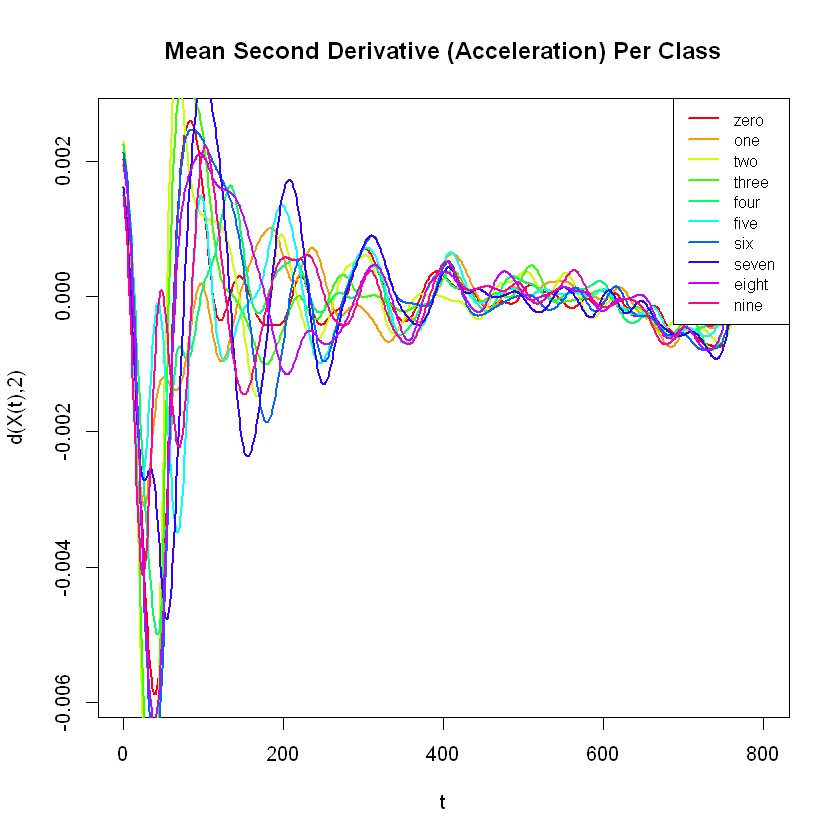

In [29]:
mean_first_derivative <- list()
mean_second_derivative <- list()

for (class in levels(dataset$labels)) {
  class_indices <- which(dataset$labels == class)

  mean_first_derivative[[class]] <- fda.usc::func.mean(
    first_derivative[class_indices, ]
  )
  mean_second_derivative[[class]] <- fda.usc::func.mean(
    second_derivative[class_indices, ]
  )
}

class_colors <- rainbow(length(levels(dataset$labels)))

plot(
  mean_first_derivative[[1]],
  main = "Mean First Derivative (Slope) Per Class",
  col = class_colors[1], lwd = 2, lty = 1
)

for (i in 2:length(levels(dataset$labels))) {
  lines(mean_first_derivative[[i]], col = class_colors[i], lwd = 2, lty = 1)
}

legend(
  "topright",
  legend = levels(dataset$labels),
  col = class_colors,
  lty = 1, lwd = 2, cex = 0.8
)

plot(
  mean_second_derivative[[1]],
  main = "Mean Second Derivative (Acceleration) Per Class",
  col = class_colors[1], lwd = 2, lty = 1
)

for (i in 2:length(levels(dataset$labels))) {
  lines(mean_second_derivative[[i]], col = class_colors[i], lwd = 2, lty = 1)
}

legend(
  "topright",
  legend = levels(dataset$labels),
  col = class_colors,
  lty = 1, lwd = 2, cex = 0.8
)

[1] TRUE

     - SUMMARY:   fdata2pc  object   -

-With 3  components are explained  82.82 %
 of the variability of explicative variables.
 
-Variability for each component (%):
[1] 60.99 14.31  7.52
[1] TRUE

     - SUMMARY:   fdata2pc  object   -

-With 3  components are explained  65.55 %
 of the variability of explicative variables.
 
-Variability for each component (%):
[1] 48.06 11.37  6.12


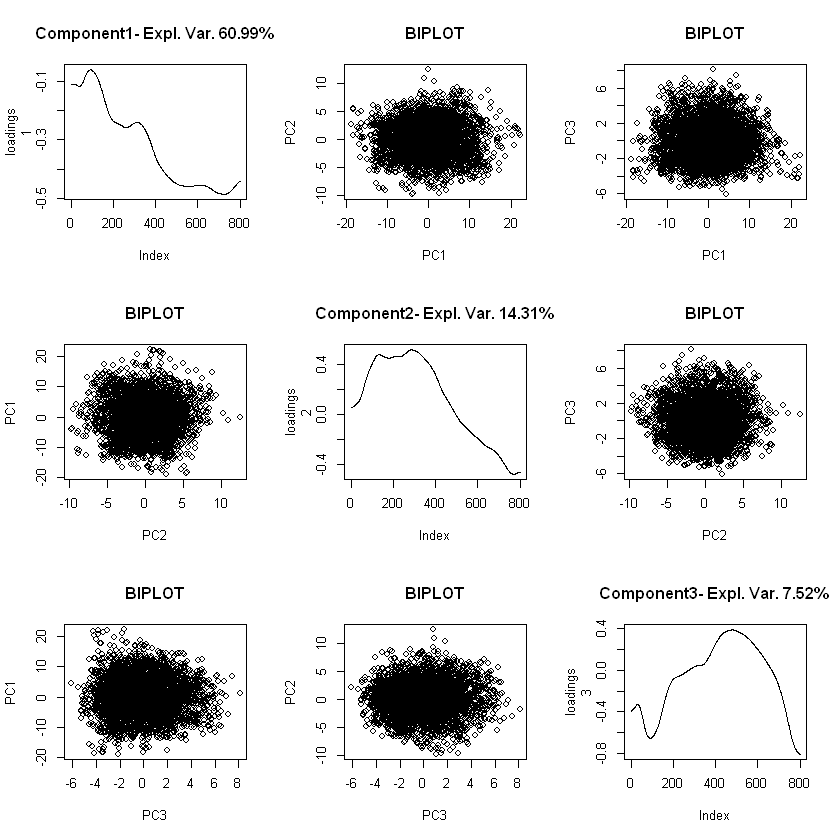

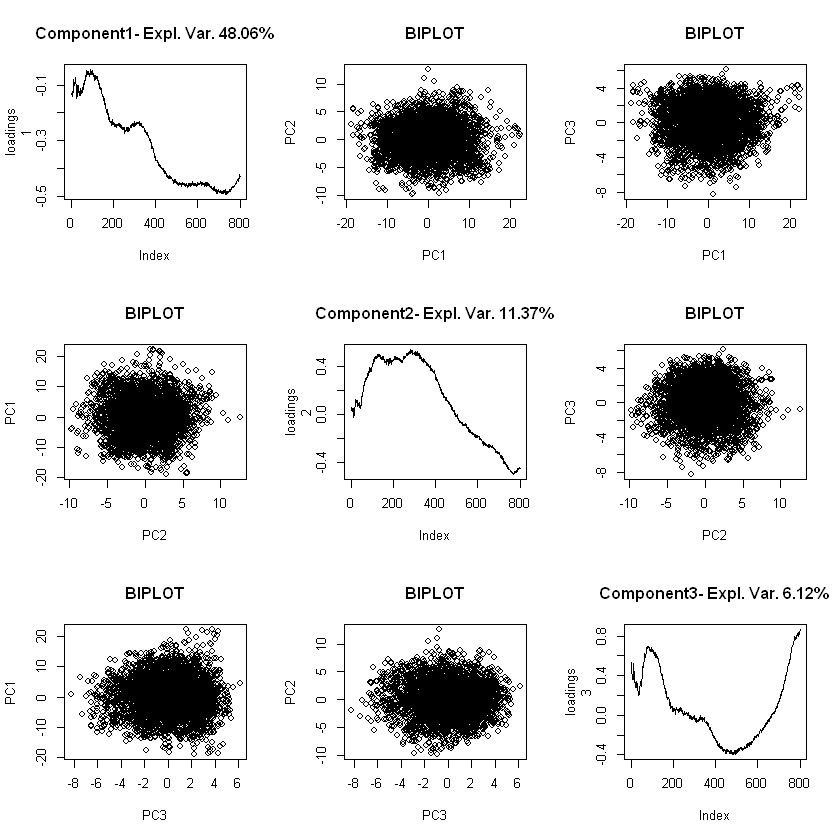

In [30]:
ncomp <- 3

fpca_smoothed <- fdata2pc(dataset$kernel$fdata.est, ncomp = ncomp)
fpca <- fdata2pc(dataset$data, ncomp = ncomp)

summary(fpca_smoothed)
summary(fpca)

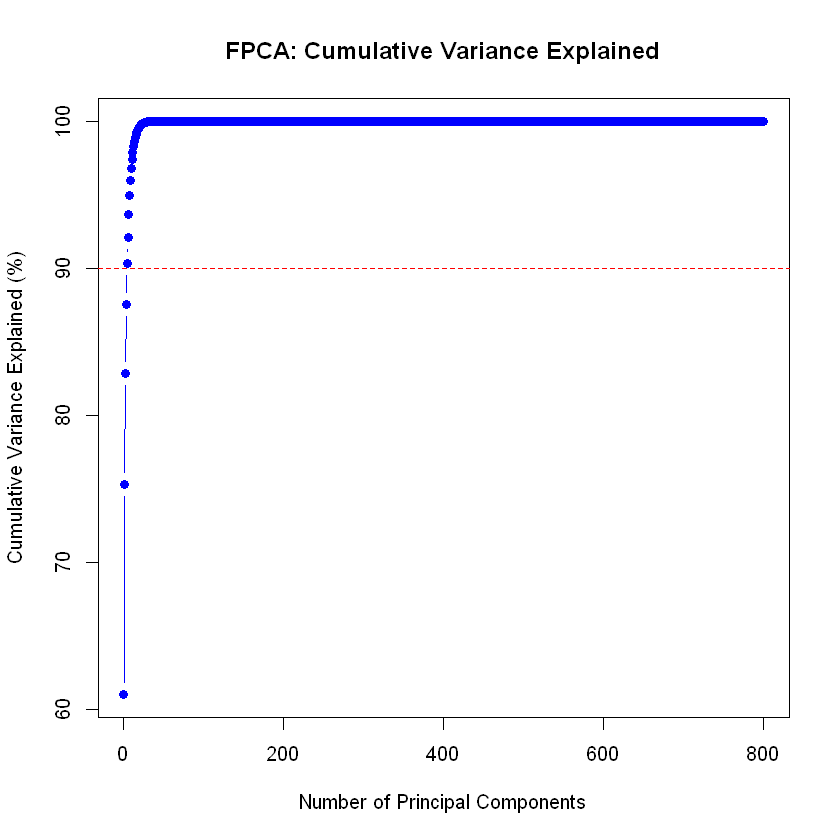

In [31]:
var_explained <- fpca_smoothed$d^2 / sum(fpca_smoothed$d^2) * 100
cumulative_var <- cumsum(var_explained)

plot(
  cumulative_var, type = "b", pch = 19, col = "blue",
  xlab = "Number of Principal Components",
  ylab = "Cumulative Variance Explained (%)",
  main = "FPCA: Cumulative Variance Explained"
)

abline(h = 90, col = "red", lty = 2)

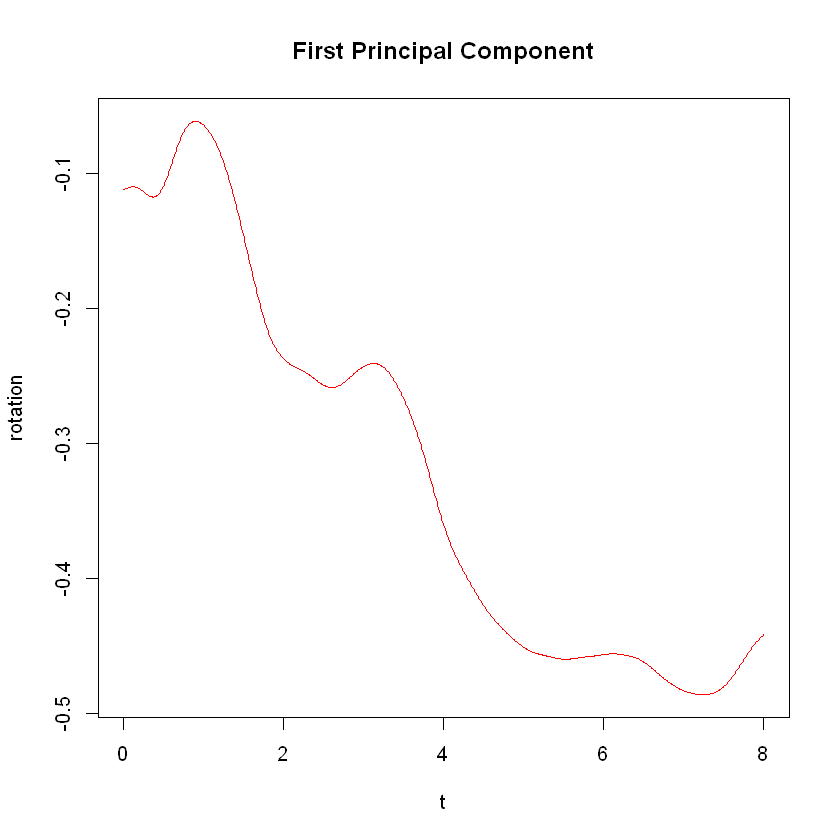

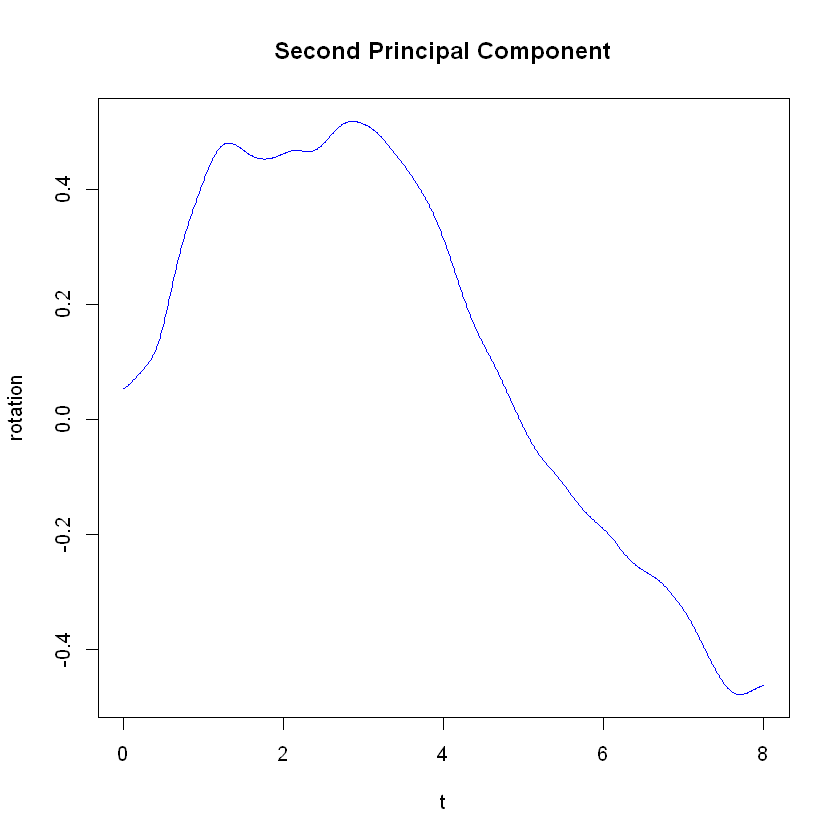

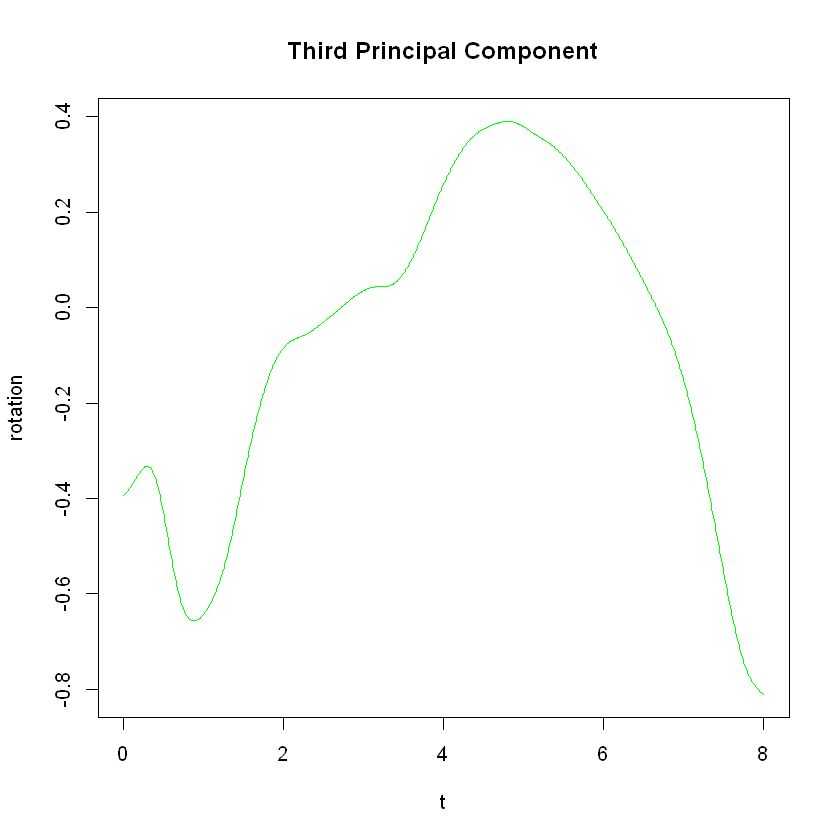

In [32]:
plot(
  fpca_smoothed$rotation[1],
  main = "First Principal Component",
  col = "red"
)

plot(
  fpca_smoothed$rotation[2],
  main = "Second Principal Component",
  col = "blue"
)

plot(
  fpca_smoothed$rotation[3],
  main = "Third Principal Component",
  col = "green"
)